In [ ]:
#connecting to google drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
#import statements
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from music21 import converter, instrument, note, chord, stream, duration
import glob
import os
from itertools import chain
import copy
import numpy as np
from tensorflow.keras.callbacks import LambdaCallback
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout
from keras.layers import CuDNNLSTM,Bidirectional
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import layers
from sklearn.model_selection import train_test_split
from numpy import argmax
from fractions import Fraction
import gc
import random
import keras.utils

In [ ]:
def data_extractor(directory):
  """
    Summary:
    Function converts midi files to metadata and appends nested metadata lists into one large list
    composed of all the songs in the dataset.

    Parameters:
    directory: String representation of directory where midi files are located

    Returns:
    list: sequential midi file metadata 
   """
  notes = []
  offsets = []
  durations = []
  for file in glob.glob(directory):
          mid = converter.parse(file)
          notes_to_parse = None
          prev_offset = 0
          
          try: 
              s2 = instrument.partitionByInstrument(mid)
              notes_to_parse = s2.parts[0].recurse() 
              
          except: 
              notes_to_parse = mid.flat.notes

          for i,element in enumerate(notes_to_parse):
              if isinstance(element, note.Note):
                  notes.append(str(element.pitch))
                  
                  durations.append(str(element.quarterLength))
                  
                  offset_dif = float(element.offset-prev_offset)
              
                  offsets.append(round(offset_dif,3))
                  prev_offset = element.offset
             
                 
              elif isinstance(element, chord.Chord):
                  notes.append('.'.join(str(n) for n in element.normalOrder))
                  offset_dif = float(element.offset-prev_offset)

                  durations.append(str(element.quarterLength))
                  
                  offsets.append(round(offset_dif,3))
                  prev_offset = element.offset

  return [notes,offsets,durations]

In [ ]:
#reading in data
data = data_extractor("/content/drive/MyDrive/midi_stuff/*.mid")
note_data = data[0]
offset_data = data[1]
duration_data = data[2]
#creating variables for unique data and unique data lengths
unique_note_number = len(list(set(note_data)))
unique_notes = sorted(list(set(note_data)))
unique_offset_number = len(list(set(offset_data)))
unique_offsets = sorted(list(set(offset_data)))
unique_duration_number = len(list(set(duration_data)))
unique_durations = sorted(list(set(duration_data)))

In [ ]:
def one_hot_encode(vector, all_values):
   """
    Summary:
    Function one hot encodes data.

    Parameters:
    vector: array to one hot encode
    all_values: array set of the vector parameter

    Returns:
    list: one hot encoded data
   """
  encoded_vectors = []
  int_to_index = dict((c, i) for i, c in enumerate(all_values))
  for i in vector:
    zero = [0]*(len(all_values)-1)
    zero.insert(int_to_index[i],1)
    encoded_vectors.append(zero)
  
  return encoded_vectors

In [ ]:
def one_hot_decode(vector,all_values):
     """
    Summary:
    Function one hot decodes the encoded data.

    Parameters:
    vector: array to one hot decode
    all_values: array set of the vector parameter

    Returns:
    list: one hot decoded data
   """
  decoded_vector = []
  index_to_int = dict((i, c) for i, c in enumerate(all_values))
  decoded_vector.append(index_to_int[argmax(vector)])
  return decoded_vector

In [ ]:
segment_length = 64
def make_segments(data_array,unique_values, seq_length = segment_length):
     """
    Summary:
    Splits data into segements with length segment_length

    Parameters:
    data_array: data to split into segments
    unique_values: array set of the data_array parameter
    seq_length: length of each sequence

    Returns:
    array tuple: array[0] = input data, array[1] = output data
   """
  input_seq = []
  output_seq = []

  processed_data = one_hot_encode(data_array,unique_values)
  
  for i in range(0,len(processed_data) - seq_length,1):
    input_seq.append([processed_data[i:i+seq_length]])
    output_seq.append(processed_data[seq_length + i])

  del processed_data;gc.collect()
  
  input_seq = np.reshape(input_seq,(len(input_seq), segment_length,len(unique_values)))
  output_seq = np.array(output_seq)

  return input_seq, output_seq

In [ ]:
#making segments for notes, offsets, and durations and garabge collecting unused varaibles to get RAM back
note_model_data = make_segments(data_array = note_data, unique_values = unique_notes)
del note_data
gc.collect()
offset_model_data = make_segments(data_array = offset_data, unique_values = unique_offsets)
del offset_data
gc.collect()
duration_model_data = make_segments(data_array = duration_data, unique_values = unique_durations)
del duration_data
gc.collect()

In [ ]:
#splitting notes, offsets, and durations into training and testing data
X_train_note, X_test_note, y_train_note, y_test_note = train_test_split(note_model_data[0], note_model_data[1],test_size=0.2)
X_train_off, X_test_off, y_train_off, y_test_off = train_test_split(offset_model_data[0], offset_model_data[1],test_size=0.2)
X_train_dur, X_test_dur, y_train_dur, y_test_dur = train_test_split(duration_model_data[0], duration_model_data[1],test_size=0.2)

In [ ]:
#garabage collecting unused variables
del note_model_data
del offset_model_data
del duration_model_data
gc.collect()

0

In [ ]:
def make_model(input_shape,output_shape):
  """
    Summary:
    Defines and compiles the LSTM model

    Parameters:
    input_shape: LSTM input shape
    output_shape: LSTM output nshape

    Returns:
    Keras Model: Compiled Model
   """
  model = Sequential()
  model.add(CuDNNLSTM(512,input_shape=input_shape,return_sequences=False))
  model.add(Dropout(0.25))
  model.add(Dense(128))
  model.add(Dense(output_shape,activation = 'softmax'))

  model.compile(
      loss='categorical_crossentropy',
      optimizer=Adam(learning_rate = .001),
      metrics=['accuracy']
  )
  return model

In [ ]:
#makes note, offset, and duration model objects
model_notes = make_model(input_shape = (segment_length,unique_note_number), output_shape = unique_note_number)
model_offsets = make_model(input_shape = (segment_length,unique_offset_number), output_shape = unique_offset_number)
model_durations = make_model(input_shape = (segment_length,unique_duration_number), output_shape = unique_duration_number)

In [ ]:
#defines callabcks for training
my_callbacks = [tf.keras.callbacks.EarlyStopping(patience=4)]

In [ ]:
#fits the note model to train data
history_note = model_notes.fit(X_train_note,y_train_note,epochs=150, validation_split = 0.2, callbacks = my_callbacks)

Epoch 1/150
1313/1313 [==============================] - 21s 14ms/step - loss: 4.2285 - accuracy: 0.0556 - val_loss: 3.8257 - val_accuracy: 0.1048
Epoch 2/150
1313/1313 [==============================] - 18s 14ms/step - loss: 3.6490 - accuracy: 0.1228 - val_loss: 3.5302 - val_accuracy: 0.1522
Epoch 3/150
1313/1313 [==============================] - 18s 14ms/step - loss: 3.3597 - accuracy: 0.1730 - val_loss: 3.2836 - val_accuracy: 0.1934
Epoch 4/150
1313/1313 [==============================] - 18s 14ms/step - loss: 3.1441 - accuracy: 0.2123 - val_loss: 3.0950 - val_accuracy: 0.2290
Epoch 5/150
1313/1313 [==============================] - 18s 14ms/step - loss: 2.9672 - accuracy: 0.2473 - val_loss: 2.9712 - val_accuracy: 0.2565
Epoch 6/150
1313/1313 [==============================] - 18s 14ms/step - loss: 2.7718 - accuracy: 0.2868 - val_loss: 2.8616 - val_accuracy: 0.2807
Epoch 7/150
1313/1313 [==============================] - 18s 14ms/step - loss: 2.5603 - accuracy: 0.3309 - val_loss: 2

In [ ]:
#fits the offset model to train data
history_offset = model_offsets.fit(X_train_off,y_train_off,epochs=150, validation_split = 0.2,callbacks = my_callbacks)

Epoch 1/150
1313/1313 [==============================] - 15s 11ms/step - loss: 0.9830 - accuracy: 0.6367 - val_loss: 0.8192 - val_accuracy: 0.7017
Epoch 2/150
1313/1313 [==============================] - 14s 11ms/step - loss: 0.7710 - accuracy: 0.7188 - val_loss: 0.7605 - val_accuracy: 0.7248
Epoch 3/150
1313/1313 [==============================] - 14s 11ms/step - loss: 0.7095 - accuracy: 0.7422 - val_loss: 0.6817 - val_accuracy: 0.7502
Epoch 4/150
1313/1313 [==============================] - 14s 11ms/step - loss: 0.6622 - accuracy: 0.7581 - val_loss: 0.6558 - val_accuracy: 0.7593
Epoch 5/150
1313/1313 [==============================] - 14s 11ms/step - loss: 0.6250 - accuracy: 0.7718 - val_loss: 0.6169 - val_accuracy: 0.7783
Epoch 6/150
1313/1313 [==============================] - 14s 11ms/step - loss: 0.5878 - accuracy: 0.7883 - val_loss: 0.6006 - val_accuracy: 0.7890
Epoch 7/150
1313/1313 [==============================] - 14s 11ms/step - loss: 0.5490 - accuracy: 0.8028 - val_loss: 0

In [ ]:
#fits the duration model to train data
history_duration = model_durations.fit(X_train_dur,y_train_dur,epochs=150, validation_split = 0.2,callbacks = my_callbacks)

Epoch 1/150
1313/1313 [==============================] - 16s 11ms/step - loss: 1.1117 - accuracy: 0.6590 - val_loss: 1.0757 - val_accuracy: 0.6579
Epoch 2/150
1313/1313 [==============================] - 14s 11ms/step - loss: 1.0204 - accuracy: 0.6770 - val_loss: 1.0148 - val_accuracy: 0.6800
Epoch 3/150
1313/1313 [==============================] - 14s 11ms/step - loss: 0.9700 - accuracy: 0.6928 - val_loss: 0.9770 - val_accuracy: 0.6909
Epoch 4/150
1313/1313 [==============================] - 14s 11ms/step - loss: 0.9287 - accuracy: 0.7076 - val_loss: 0.9428 - val_accuracy: 0.6979
Epoch 5/150
1313/1313 [==============================] - 14s 11ms/step - loss: 0.8842 - accuracy: 0.7217 - val_loss: 0.9300 - val_accuracy: 0.7133
Epoch 6/150
1313/1313 [==============================] - 14s 11ms/step - loss: 0.8413 - accuracy: 0.7366 - val_loss: 0.8684 - val_accuracy: 0.7331
Epoch 7/150
1313/1313 [==============================] - 14s 11ms/step - loss: 0.7817 - accuracy: 0.7536 - val_loss: 0

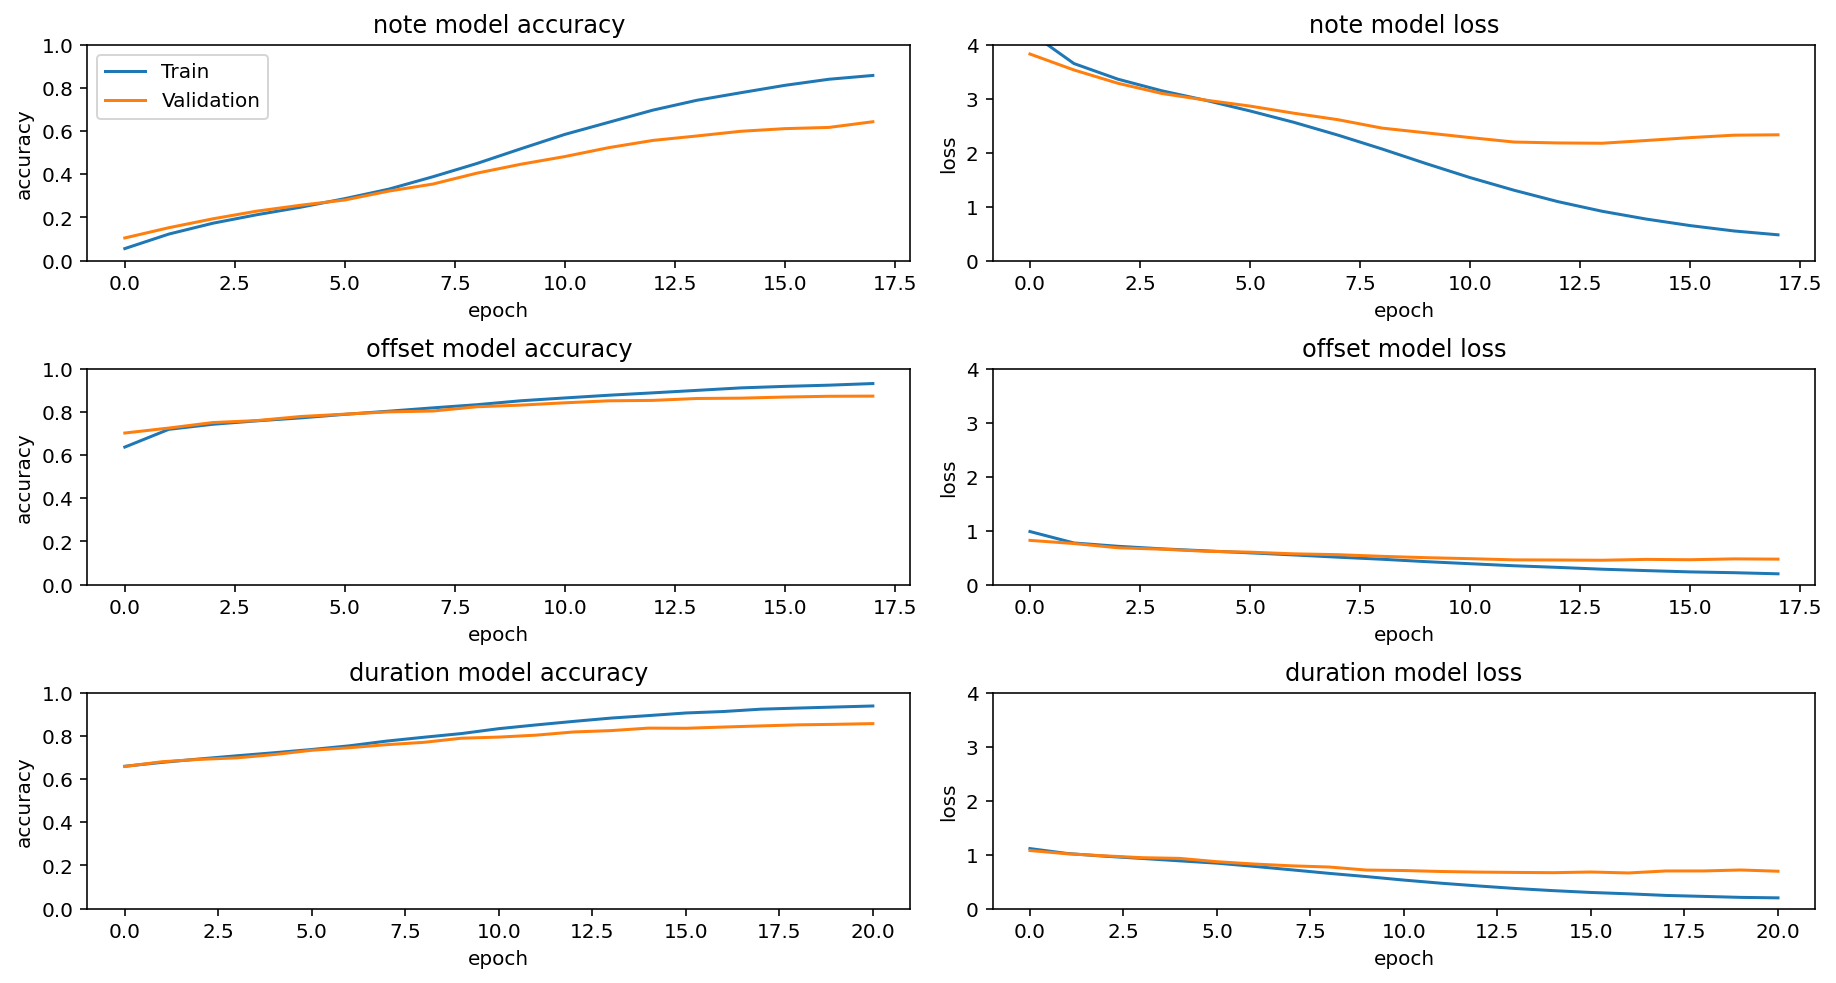

In [ ]:
#plotting model results
plt.subplot(3,2,1)
plt.plot(history_note.history['accuracy']);plt.plot(history_note.history['val_accuracy']);plt.title('note model accuracy');plt.ylabel('accuracy');plt.xlabel('epoch');plt.legend(['Train', 'Validation'], loc='upper left');plt.ylim(0,1)
plt.subplot(3,2,2)
plt.plot(history_note.history['loss']);plt.plot(history_note.history['val_loss']);plt.title('note model loss');plt.ylabel('loss');plt.xlabel('epoch');plt.ylim(0,4)
plt.subplot(3,2,3)
plt.plot(history_offset.history['accuracy']);plt.plot(history_offset.history['val_accuracy']);plt.title('offset model accuracy');plt.ylabel('accuracy');plt.xlabel('epoch');plt.ylim(0,1)
plt.subplot(3,2,4)
plt.plot(history_offset.history['loss']);plt.plot(history_offset.history['val_loss']);plt.title('offset model loss');plt.ylabel('loss');plt.xlabel('epoch');plt.ylim(0,4)
plt.subplot(3,2,5)
plt.plot(history_duration.history['accuracy']);plt.plot(history_duration.history['val_accuracy']);plt.title('duration model accuracy');plt.ylabel('accuracy');plt.xlabel('epoch');plt.ylim(0,1)
plt.subplot(3,2,6)
plt.plot(history_duration.history['loss']);plt.plot(history_duration.history['val_loss']);plt.title('duration model loss');plt.ylabel('loss');plt.xlabel('epoch');plt.ylim(0,4)
plt.subplots_adjust(left=0, 
                    bottom=0,  
                    right=2.0,  
                    top=1.5,  
                    wspace=0.1,  
                    hspace=0.5)


In [ ]:
def sample(preds, temperature=1.0):
    """Helper function to sample an index from a probability array."""
    preds = np.asarray(preds).astype('float64')
    preds = np.exp(np.log(preds) / temperature)  
    preds = preds / np.sum(preds)                
    probas = np.random.multinomial(1, preds, 1)  
    return np.argmax(probas)                     

In [ ]:
def music_maker(seed_vec, model_type, number_unique, unique, diversity, num_notes = 100):
   """
    Summary:
    Generates new data from seed

    Parameters:
    seed_vec: random seed from the training data
    model_type: model object correspodning to type of seed_vec (note, offset, or durration)
    number_unique: number of unique notes in seed_vec
    unique: unique notes in seed_vec
    diversity: diversity (temperature) value
    num)_notes: number of new notes to generate

    Returns:
    list: generated data
   """
  music = []
  arr = np.zeros((len(seed_vec)+num_notes,number_unique))
  for c,i in enumerate(seed_vec):
    arr[c] = i

  for i in range(0,num_notes,1):
    d_arr = np.zeros(number_unique)
    pred = model_type.predict(np.reshape(arr[i:len(arr)-num_notes+i], (1, len(arr[i:len(arr)-num_notes+i]),number_unique)),verbose = 0)[0]
    diverse = sample(pred, diversity)
    d_arr[diverse] = 1
    music.append(one_hot_decode(d_arr,all_values = unique)[0])

    arr[len(seed_vec)+i] = d_arr
  
  return music

In [ ]:
#samples a random numebr from the testing data to use as a seed and generates new data based on the seed
randnum = random.randrange(0,len(X_test_note))
test_note = X_test_note[randnum]
test_offset = X_test_off[randnum]
test_dur = X_test_dur[randnum]
generated_music_note = music_maker(test_note, model_notes, unique_note_number, unique_notes, 0.7)
generated_music_offset = music_maker(test_offset,model_offsets,unique_offset_number, unique_offsets, 0.7)
generated_music_duration = music_maker(test_dur, model_durations, unique_duration_number, unique_durations, 0.2)

471


In [ ]:
#converts the seed back to the original midi metadata
seed_notes = []
seed_offsets = []
seed_durations = []
for n in test_note:
  seed_notes.append(one_hot_decode(n ,unique_notes)[0]) 
for o in test_offset:
  seed_offsets.append(one_hot_decode(o ,unique_offsets)[0]) 
for d in test_dur:
  seed_durations.append(one_hot_decode(d, unique_durations)[0])

In [ ]:
def to_midi(notes, offsets, durations):
  """
  Summary:
  Takes midi metadata and converts it to a Music21 stream. The stream can then easily be converted into a midi file.

  Parameters:
  notes: note metadata
  offsets: offset metadata
  durations: durations metadata

  Returns:
  Music21 stream object
  """
  offset = offsets[0]
  s = stream.Stream()
  for i,ele in enumerate(notes):
    if ele[0].isalpha():
      n = note.Note(ele)
      try:
        n.quarterLength = float(durations[i])
      except:
        n.quarterLength = Fraction(durations[i])

      s.insert(offset,n)

      offset += offsets[i]
    else:
      chords = list(map(int,ele.split('.')))
      c = chord.Chord(chords)

      try:
        c.quarterLength = float(durations[i])
      except:
        c.quarterLength = Fraction(durations[i])

      s.insert(offset,c)

      offset += offsets[i]
  return s

In [ ]:
#converts the generated music to a midi file
to_midi(generated_music_note,generated_music_offset, generated_music_duration).write('midi', "generated_classical_final.mid")
#converts the seed to a midi file
to_midi(seed_notes,seed_offsets,seed_durations).write('midi', "seed_classical_final.mid")


'seed_classical_final.mid'